In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os
import numpy as np

In [5]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

/Users/j35/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
from PyQt4 import QtGui

In [7]:
import scipy as sp
import imreg_dft as ird

In [8]:
import skimage
from skimage.feature import register_translation

## Select Working Folder

In [9]:
%gui qt

In [10]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_fname(dir=None, message=None):
    """Select a directory
    """
    if dir is None: dir ='../'
    if message is None: message = 'Select Folder ...'
    dir_name = QtGui.QFileDialog.getExistingDirectory(None, message,
                                                      dir,
                                                      QtGui.QFileDialog.ShowDirsOnly)
    return dir_name

In [28]:
%gui qt
data_folder = gui_fname()
%matplotlib inline

In [31]:
# remove hidden file .DS_Store 
ds_file = os.path.join(data_folder, ".DS_Store")
try:
    os.remove(ds_file)
except:
    pass

In [32]:
list_of_files = [name for name in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, name))]
number_of_files = len(list_of_files)
print('Folder contains %d files.' %number_of_files)

Folder contains 966 files.


### Load the first image (template) and will loop through the other images to get the offsets

### loading template

In [33]:
template_file = os.path.join(data_folder, list_of_files[0])
im_template = sp.misc.imread(template_file)
if len(im_template.shape) == 3:
    im_template = im_template[:, :, 0]
im_template.shape

(254, 140)

### Start looping through the other images

In [34]:
registered_images = []
registered_images.append(im_template)

In [35]:
def translate_array(old_array, xoffset, yoffset, index):
    
    [ysize, xsize] = old_array.shape
    new_array = np.zeros((ysize, xsize))
    
    if False:
        print('working with image at index %d' %index)
        print('xoffset: %f' %xoffset)
        print('yoffset: %f' %yoffset)
        print()
        
    if (xoffset < 0):
        old_array_from_x = abs(xoffset)
        old_array_to_x = xsize
        new_array_from_x = 0
        new_array_to_x = xsize - abs(xoffset)

    elif (xoffset > 0):
        old_array_from_x = 0
        old_array_to_x = xsize - xoffset
        new_array_from_x = xoffset
        new_array_to_x = xsize
    
    else:
        old_array_from_x = 0
        old_array_to_x = xsize
        new_array_from_x = 0
        new_array_to_x = xsize
    
    if (yoffset < 0):
        old_array_from_y = abs(yoffset)
        old_array_to_y = ysize
        new_array_from_y = 0
        new_array_to_y = ysize - abs(yoffset)
    
    elif (yoffset > 0):
        old_array_from_y = 0
        old_array_to_y = ysize - yoffset
        new_array_from_y = yoffset
        new_array_to_y = ysize
    
    else:
        old_array_from_y = 0
        old_array_to_y = ysize
        new_array_from_y = 0
        new_array_to_y = ysize
   
    if False:
        print('working with x')
        print("old_array_from_x: %d" %old_array_from_x)
        print("old_array_to_x: %d" %old_array_to_x)
        print()
        print("new_array_from_x: %d" %new_array_from_x)
        print("new_array_to_x: %d" %new_array_to_x)

        print("\n")
        print("working with Y")
        print("old_array_from_y: %d" %old_array_from_y)
        print("old_array_to_y: %d" %old_array_to_y)
        print()
        print("new_array_from_y: %d" %new_array_from_y)
        print("new_array_to_y: %d" %new_array_to_y)
    
    
    new_array[new_array_from_y: new_array_to_y, new_array_from_x: new_array_to_x] = \
    old_array[old_array_from_y: old_array_to_y, old_array_from_x: old_array_to_x]
    
    return new_array

In [36]:
w = widgets.IntProgress()
w.max = (number_of_files-1)
display(w)

for index in range(1, number_of_files):
    
    im_index = sp.misc.imread(os.path.join(data_folder, list_of_files[index]))
    if len(im_index.shape) == 3:
        im_index = im_index[:, :, 0]

    shift, error, diffphase = register_translation(im_template, im_index)
    
    [yoffset, xoffset] = shift
    
    new_array = translate_array(im_index, int(xoffset), int(yoffset), index)
    registered_images.append(new_array)
    
    w.value = index

## Check results

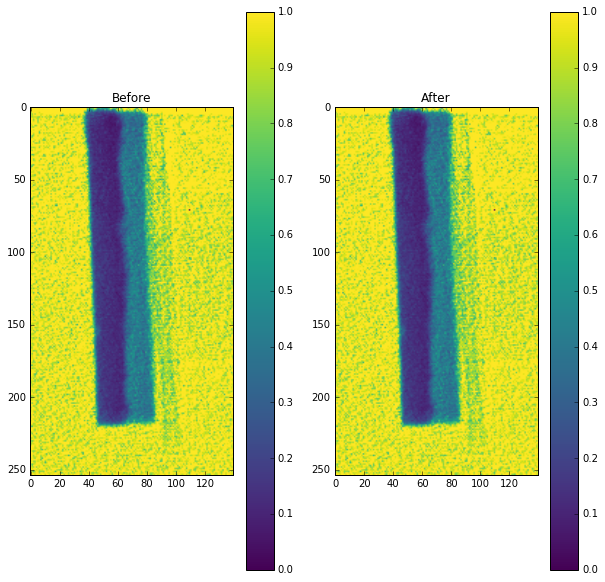

In [37]:
def plot_results(index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img_b = plt.subplot(1,2,1)

    data_before = sp.misc.imread(os.path.join(data_folder, list_of_files[index]))
    im1 = ax_img_b.imshow(data_before, cmap='viridis')
    ax_img_b.set_title("Before")
    plt.colorbar(im1, ax=ax_img_b)
    
    ax_img_a = plt.subplot(1,2,2)
    data_after = registered_images[index]
    im2 = ax_img_a.imshow(data_after, cmap='viridis')
    ax_img_a.set_title('After')
    plt.colorbar(im2, ax=ax_img_a)
    
interact(plot_results, 
        index = widgets.IntSlider(min=0, max=number_of_files-1, step=1, value=0))
    

## Export files

In [38]:
from PIL import Image

In [39]:
%gui qt
output_folder = gui_fname()
%matplotlib inline

In [40]:
w = widgets.IntProgress()
w.max = (number_of_files-1)
display(w)

for index in range(1, number_of_files):
    output_filename = os.path.join(output_folder, list_of_files[index])
    _im = registered_images[index]
    _new_im = Image.fromarray(np.float32(_im))
    _new_im.save(output_filename)
    w.value = index